# Fluorescence polarization

In [1]:
from io import StringIO
from pathlib import Path
from itertools import repeat
from operator import itemgetter
from collections import namedtuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

## Read data

In [2]:
folder = Path('data/fluorescence-polarization')  # path to data

In [3]:
def read(csv_file: Path):
    content = csv_file.read_text()
    data = content.partition('\n\n')[0]
    file = StringIO(data)
    df = pd.read_csv(
        file, skiprows=2, names=['wavelength', 'intensity'], usecols=[0, 1]
    )
    return df

In [4]:
def get_data(folder: Path):
    d = {}
    for p in folder.glob('*.csv'):
        d[p.stem] = read(p)
    return pd.Series(d)

In [5]:
all_data = get_data(folder).sort_index()

## Curve fitting

In [6]:
def peak(x: np.array, A=1, mu=0, sigma=1):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

In [7]:
def objective(x, *params):
    params = np.array(params).flatten()
    shape = int(len(params) / 3), 3
    peaks = np.reshape(params, shape)
    return sum(peak(x, A, mu, sigma) for A, mu, sigma in peaks)

In [8]:
Peak = namedtuple('Peak', ['A', 'mu', 'sigma'])

In [9]:
def fit_peaks(sr: pd.Series, mus, range=None, internal_sample=100):
    x = sr.index
    y = sr.values
    inits = zip(repeat(1), mus, repeat(1))
    p0 = [p for z in inits for p in z]  # flattenize

    popt, pcov = curve_fit(objective, x, y, p0=p0)
    pks = np.split(popt, len(popt) / 3)
    pks = [Peak(*pk) for pk in pks]

    return sorted(pks, key=itemgetter(1))

## Plot

In [10]:
def peak_analysis(all_data):

    fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(10, 10))
    
    intensities = {}
    peaks = {}

    Z = zip(range(1, len(all_data) + 1), all_data.items(), axs.ravel())

    for i, (k, data), ax in Z:

        data.plot(x=0, y=1, ax=ax)


        # find main peak
        smooth = gaussian_filter1d(data.intensity, 2)  # smoothing factor
        [peak_idx], _ = find_peaks(smooth, 1)  # should be the only 1, increase smoothing factor
        data.iloc[[peak_idx]].plot(x=0, y=1, style=".r", ax=ax)
        wavelength, intencity = data.iloc[peak_idx]

        title = '{no}{orients} : $\lambda = {wavelength:.0f}$ nm, $I = {intencity:.2f}$ U'.format(
            no=k[0], orients=k[1:], wavelength=wavelength, intencity=intencity
        )

        ax.set_title(title, fontsize=10)
        ax.get_legend().remove()

        intensities[(k[0], k[1:])] = intencity

        # peak decomposition
        sr = data.set_index('wavelength').intensity
        minmax = sr.index.min(), sr.index.max()

        sr.plot(ax=ax)
        x = np.linspace(*minmax, 1000)

        pks = fit_peaks(sr, [500, 540])  # adjust wavelengths
        peaks[(k[0], k[1:])] = pks
        ax.plot(x, objective(x, *pks), "r", alpha=0.5)
        [ax.plot(x, peak(x, *parms), "--", alpha=0.5) for parms in pks]

    plt.tight_layout()

    yield pd.Series(intensities).unstack(level=1)  # intensities

    def prepare_peaks(peaks: dict):
        result = []
        for k, vals in peaks.items():
            for peak in vals:
                result.append((*k, *peak))

        df = pd.DataFrame(result, columns=['no', 'orients', *peak._fields])
        df.set_index(['no', 'orients', 'mu'], inplace=True)
        return df

    yield prepare_peaks(peaks)

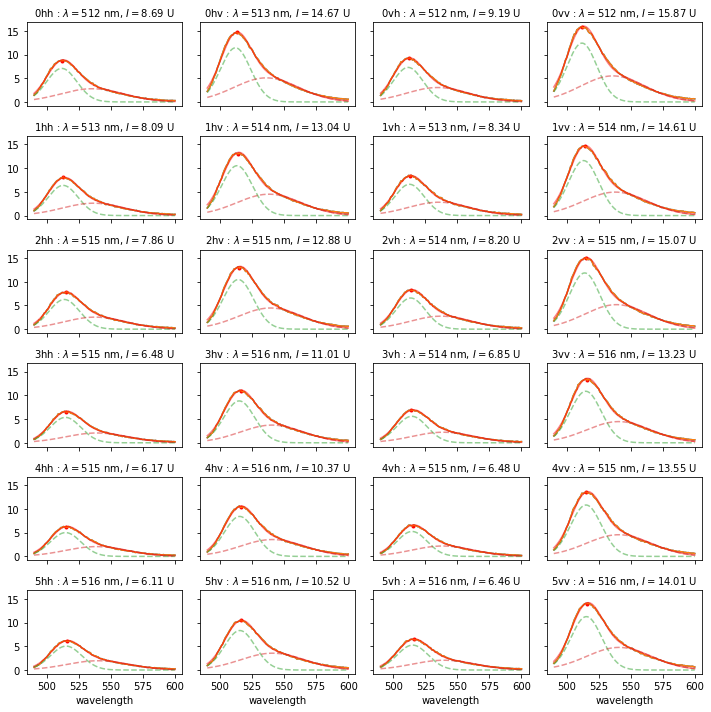

In [11]:
intensities, peaks = peak_analysis(all_data)

In [12]:
intensities["g_factor"] = intensities.hv / intensities.hh
intensities["polarization"] = intensities.apply(
    lambda x: (x.vv - x.g_factor * x.vh) / (x.vv + x.g_factor * x.vh), axis=1
)

In [13]:
intensities

,hh,hv,vh,vv,g_factor,polarization
0,8.692522,14.668288,9.187510,15.867807,1.687461,0.011611
1,8.085460,13.035077,8.340162,14.611181,1.612163,0.041540
2,7.856707,12.878545,8.202553,15.067453,1.639178,0.056887
3,6.478344,11.011899,6.853699,13.229930,1.699802,0.063505
4,6.167875,10.369456,6.478917,13.547698,1.681204,0.108646
5,6.111468,10.518697,6.460008,14.011591,1.721141,0.115121


In [14]:
peaks

A      sigma
no orients mu                               
0  hh      511.644990  208.803195  11.778944
           535.324647  171.207778  24.542726
   hv      512.053716  337.168043  11.786603
           535.985115  319.471076  25.104754
   vh      511.513513  211.027115  11.565836
           534.522378  184.710001  24.261785
   vv      511.992314  364.241755  11.717146
           536.028701  345.677411  25.112217
1  hh      512.742981  185.545447  11.641281
           536.390595  158.573596  24.280124
   hv      513.232314  314.189148  11.925300
           538.107781  280.970015  24.892846
   vh      512.587206  190.866237  11.553473
           535.584686  169.243490  24.002905
   vv      513.270031  344.185936  11.848639
           537.865414  312.049280  25.170668
2  hh      513.640995  186.332213  11.876015
           537.636525  154.788549  24.335133
   hv      514.210419  312.865764  11.934084
           539.234358  279.481123  24.983530
   vh      513.526196  191.994157  11.659337
           537.210313  166.332385  24.224574
   vv      514.092660  355.750216  11.973688
           538.826850  324.644349  25.044826
3  hh      514.535823  161.279764  12.015150
           539.078998  126.508535  24.428095
   hv      514.923531  266.280281  12.035761
           540.524314  232.028603  24.795034
   vh      514.407662  167.283368  11.952260
           538.807939  134.165140  24.053124
   vv      514.922610  330.370071  12.132724
           540.613616  281.278767  25.109393
4  hh      514.659390  150.594801  11.976600
           538.683910  125.240663  24.178784
   hv      515.309895  253.136911  11.988821
           540.754349  222.226409  24.944075
   vh      514.580871  154.845512  11.747674
           538.399596  131.477180  23.957030
   vv      515.156919  326.992293  12.038663
           540.593231  287.612671  25.106835
5  hh      515.070423  153.034928  12.110722
           540.029218  118.463911  24.137626
   hv      515.419967  250.650706  12.015015
           540.856787  221.318907  24.880198
   vh      515.058931  159.080661  12.084276
           539.488086  126.246799  24.417074
   vv      515.418936  341.024340  12.086628
           540.800892  300.043196  25.104701